## Proyecto Machine Learning

In [9]:
# Importo las librerias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
assert sys.version_info >= (3, 5)
from sklearn.svm import SVC
from sklearn import svm
import sklearn
assert sklearn.__version__ >= "0.20"
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, f1_score, recall_score, \
                            roc_auc_score
from sklearn import linear_model
from sklearn import model_selection


%matplotlib inline

In [10]:
# Abro el dataset
brain = pd.read_csv("data/healthcare-dataset-stroke-data.csv")
brain.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [11]:
# Primera idea de los datos
brain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### Información del dataset y las columnas
- **Id:** identificador único del paciente.
- **Gender:** género (Male, Female y Other).
- **Age:** la edad.
- **Hypertension:** ``0`` si el paciente NO tiene hipertensión, ``1`` si el paciente SÍ tiene hipertensión.
- **Heart_disease:** ``0`` si el paciente NO tiene ninguna enfermedad cardíaca, ``1`` si el paciente SÍ tiene enfermedad cardíaca.
- **Ever_married:** saber si el paciente está casado o no (Yes o No).
- **Work_type**: private: trabajador empresa privada, self-employed: autónomo, govt_job: trabajador empleo público, children: si es un menor, never_worked: si nunca ha trabajado.
- **Residence_type:** urban o rural.
- **avg_glucose_level:** nivel medio de glucosa en sangre.
- **bmi:** índice de masa corporal.
- **smoking_status:** formerly smoked: persona que con anterioridad fumaba, never smoked: nunca ha fumado, smokes: fumadora, unknown: información no disponible para este paciente.
- **stroke:** ``1`` si el paciente ha tenido un accidente cerebrovascular, ``0`` si no ha tenido ningún accidente.

In [12]:
# Esto es lo que quiero predecir, está muy desbalanceado, analizaré los datos originales,
# y antes de proceder a los modelos crearé datos sintéticos de 1 para que los modelos hagan mejores prediciones
print(brain.stroke.value_counts())

0    4861
1     249
Name: stroke, dtype: int64


In [13]:
# Análisis estadístico de los datos
brain.describe(include='all')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110.000000,5110,5110.000000,5110.000000,5110.000000,5110,5110,5110,5110.000000,4909.000000,5110,5110.000000
unique,NaN,3,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,NaN,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,NaN,2994,NaN,NaN,NaN,3353,2925,2596,NaN,NaN,1892,NaN
mean,36517.829354,NaN,43.226614,0.097456,0.054012,NaN,NaN,NaN,106.147677,28.893237,NaN,0.048728
std,21161.721625,NaN,22.612647,0.296607,0.226063,NaN,NaN,NaN,45.283560,7.854067,NaN,0.215320
min,67.000000,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.120000,10.300000,NaN,0.000000
25%,17741.250000,NaN,25.000000,0.000000,0.000000,NaN,NaN,NaN,77.245000,23.500000,NaN,0.000000
50%,36932.000000,NaN,45.000000,0.000000,0.000000,NaN,NaN,NaN,91.885000,28.100000,NaN,0.000000
75%,54682.000000,NaN,61.000000,0.000000,0.000000,NaN,NaN,NaN,114.090000,33.100000,NaN,0.000000


In [14]:
# Analizo los datos. Veo que hay missings en la columna 'bmi'
print(brain.info())

# Quiero ver cuantos hay, los rellenaré cuando haga train y test
print("Cantidad de missings en bmi: ",brain.bmi.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None
Cantidad de missings en bmi:  201


### Análisis exploratorio de los datos

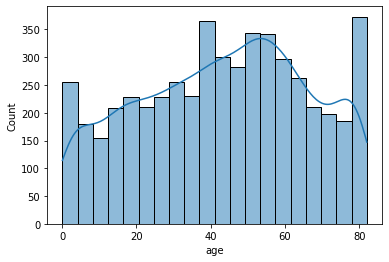

In [9]:
# Quiero saber la distribución de la edad. Para la presentación finalmente no usaré esta gráfica.
sns.histplot(brain['age'], kde=True);

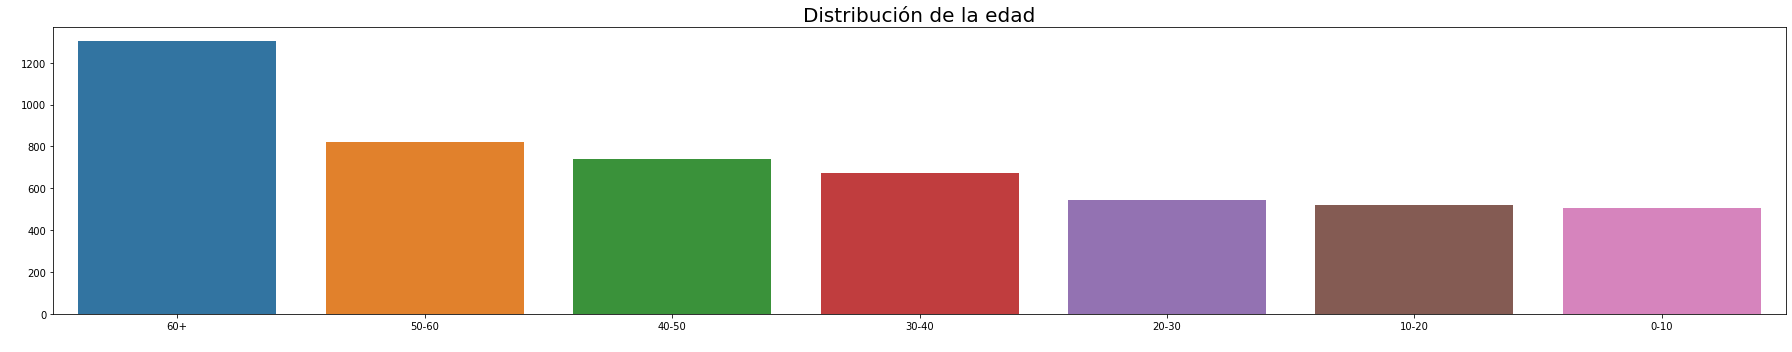

In [15]:
# Creo en una función el porcentaje para saber cómo está distribuida la edad
def age_cohort(age):
    if   age >= 0 and age <= 10:
        return "0-10"
    elif age > 10 and age <= 20:
        return "10-20"
    elif age > 20 and age <= 30:
        return "20-30"
    elif age > 30 and age <= 40:
        return "30-40"    
    elif age > 40 and age <= 50:
        return "40-50"
    elif age > 50 and age <= 60:
        return "50-60"
    elif age > 60:
        return "60+"
    
# lo pongo dentro del df, para ello, creo una nueva columna
brain['age_group'] = brain['age'].apply(age_cohort)
age = brain['age_group'].value_counts()

plt.figure(figsize=(25, 5))
sns.countplot(x = brain['age_group'], data=brain, order=brain['age_group'].value_counts().index)
plt.title('Distribución de la edad', fontsize= 20)
plt.xlabel(" ")
plt.ylabel(" ")
plt.tight_layout()


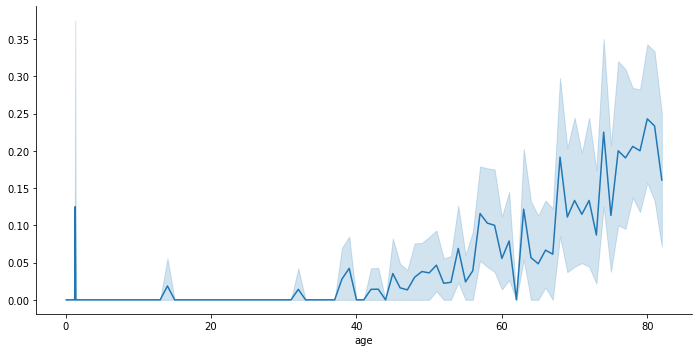

In [16]:
# Quiero ver la relación entre la edad y el target
sns.relplot(
    data=brain, 
    x="age", y="stroke", 
    height=5, aspect=2, 
    kind="line")
plt.ylabel('')
plt.savefig('./img/porcentajeedadreplot.png') 

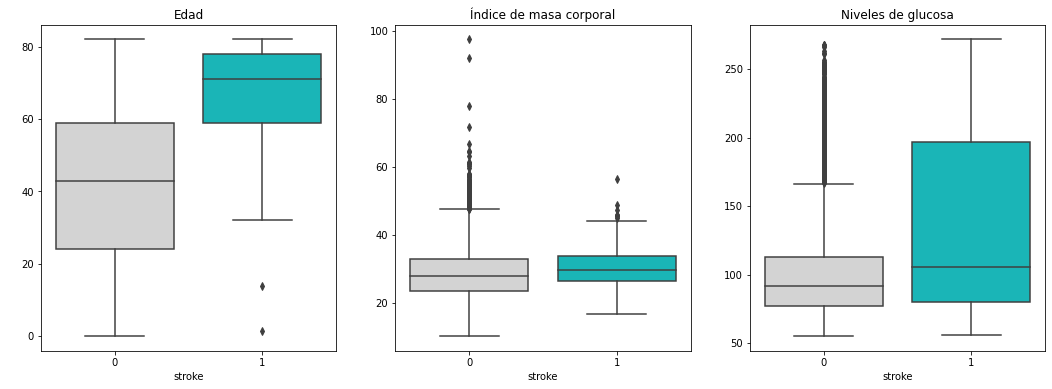

In [17]:
# Quiero ver los outliers y seguir análizando los datos.
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 6) , squeeze=True)
sns.boxplot(data=brain,y=brain['age'],x=brain['stroke'],palette=["#D3D3D3",'#00CED1'] , ax=axes[0]).set(title= 'Edad', ylabel= ' ')
sns.boxplot(data=brain,y=brain['bmi'],x=brain['stroke'],palette=["#D3D3D3",'#00CED1'] , ax=axes[1]).set(title= 'Índice de masa corporal', ylabel= ' ')
sns.boxplot(data=brain,y=brain['avg_glucose_level'],x=brain['stroke'],palette=["#D3D3D3",'#00CED1'] , ax=axes[2]).set(title= 'Niveles de glucosa', ylabel= ' ');
plt.savefig('./img/boxplotedadbmiglc.png') 

In [18]:
# Elimino los outliers en la columna 'bmi', confirmo además de que no estan en las mismas filas que stroke
print(brain[brain['bmi']>70])

# Compruebo el tamaño antes de eliminarlo
print("Tamaño con el outlier sin eliminar: ", brain.shape)

# Elimino el outlier
brain = brain.drop(brain.index[brain['bmi']>70]) 

# Compruebo el tamaño con el outlier eliminado
print("Tamaño con el outlier eliminado:", brain.shape)

# Elimino los de índice de masa corporal puesto que creo que son datos erróneos, en cambio en los niveles
# de glucosa, es raro, pero es mucho más posible que estén así, lo mismo con los dos que salen en el target con la edad.

         id  gender   age  hypertension  heart_disease ever_married work_type  \
544     545    Male  42.0             0              0          Yes   Private   
928   41097  Female  23.0             1              0           No   Private   
2128  56420    Male  17.0             1              0           No   Private   
4209  51856    Male  38.0             1              0          Yes   Private   

     Residence_type  avg_glucose_level   bmi smoking_status  stroke age_group  
544           Rural             210.48  71.9   never smoked       0     40-50  
928           Urban              70.03  78.0         smokes       0     20-30  
2128          Rural              61.67  97.6        Unknown       0     10-20  
4209          Rural              56.90  92.0   never smoked       0     30-40  
Tamaño con el outlier sin eliminar:  (5110, 13)
Tamaño con el outlier eliminado: (5106, 13)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group


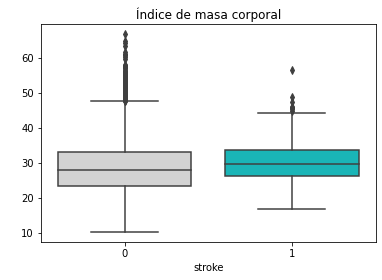

In [19]:
# Compruebo que ya no encuentra las columnas  
display(brain[brain['bmi']>70])

# Compuebo los boxplots de nuevo ahora sin outliers
sns.boxplot(data=brain,y=brain['bmi'],x=brain['stroke'],palette=["#D3D3D3",'#00CED1']).set(title= 'Índice de masa corporal', ylabel= ' ')
plt.savefig('./img/boxplotedadbmiglcsinoutliers.png') 

never smoked       1890
Unknown            1543
formerly smoked     885
smokes              788
Name: smoking_status, dtype: int64


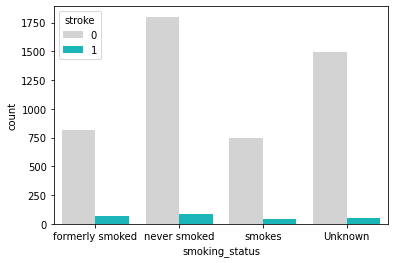

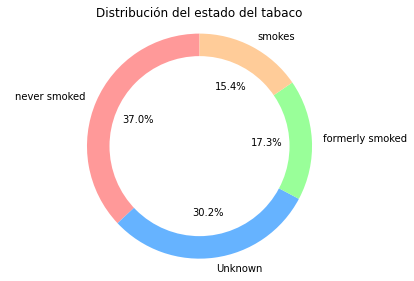

In [20]:
# Quiero ver cómo está distribuido el estado del fumador

# Creo una función para los countplots
def countplot(count,trg,df):
    sns.countplot(x=count, hue=trg, palette=["#D3D3D3",'#00CED1'], data=df);
plt.savefig('./img/smokingcountplot.png')    

countplot('smoking_status', 'stroke', brain)

#Creo una función de pie chart
def pie(df, title):
    
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#9370D8']
    fig1, ax1 = plt.subplots()
    ax1.pie(df, colors = colors, labels=df.index, autopct='%1.1f%%', startangle=90)
    centre_circle = plt.Circle((0,0),0.80,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    ax1.axis('equal')  
    plt.title(title)
    plt.tight_layout();


smoking = brain['smoking_status'].value_counts()
pie(smoking, "Distribución del estado del tabaco");
plt.savefig('./img/distribucionsmoking.png') 

print(brain.smoking_status.value_counts())

Private          2921
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


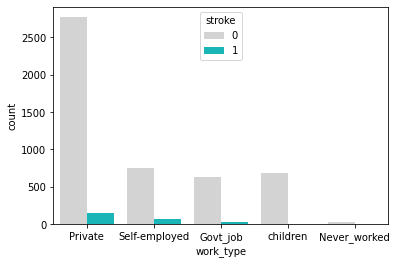

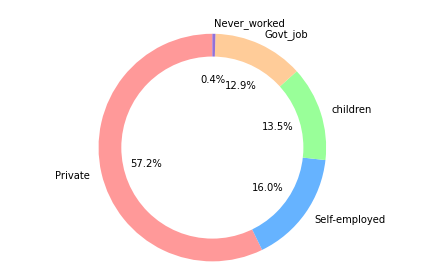

In [21]:
# Quiero ver cómo está distribuido el tipo de trabajo
countplot('work_type', 'stroke', brain)
plt.savefig('./img/countplotworktype.png') 

work_type = brain['work_type'].value_counts()
pie(work_type, ' ')
plt.savefig('./img/distribucionworktype.png') 

print(brain.work_type.value_counts())

0    4611
1     495
Name: hypertension, dtype: int64
0    4611
1     495
Name: hypertension, dtype: int64


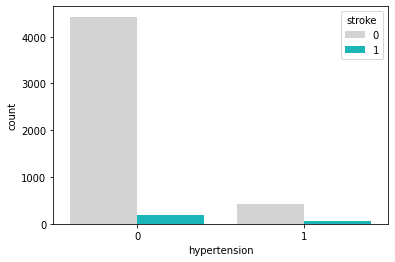

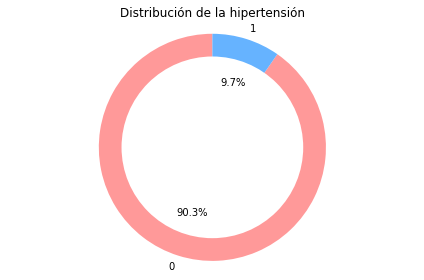

In [32]:
# Quiero ver cómo está distribuida la hipertensión
countplot('hypertension', 'stroke', brain)
plt.savefig('./img/distribuciohipertension.png') 

print(brain.hypertension.value_counts())
work_type = brain['hypertension'].value_counts()
pie(work_type, 'Distribución de la hipertensión') 
plt.savefig('./img/distribucionhipertensionpie.png')  

print(brain.hypertension.value_counts())

Urban    2595
Rural    2511
Name: Residence_type, dtype: int64


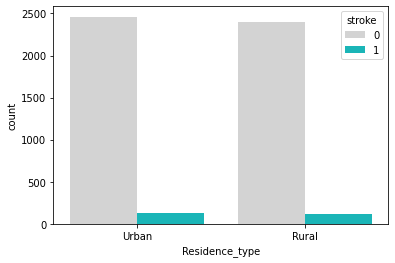

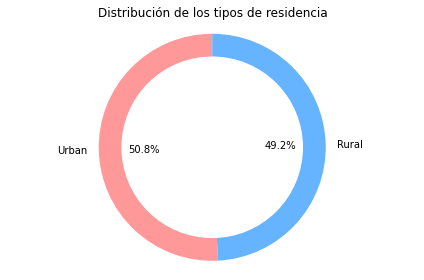

In [33]:
# Quiero ver cómo está distribuido el tipo de residencia
countplot('Residence_type', 'stroke', brain)
plt.savefig('./img/distribucioresidencetypecountplot.png') 

residence_type = brain['Residence_type'].value_counts()
pie(residence_type, 'Distribución de los tipos de residencia')
plt.savefig('./img/distribucioresidencetype.png') 

print(brain.Residence_type.value_counts())

Female    2993
Male      2112
Other        1
Name: gender, dtype: int64


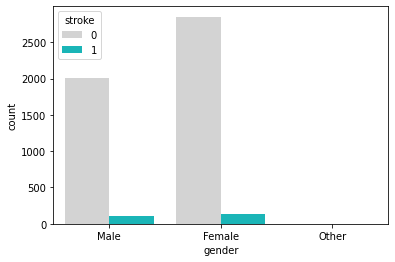

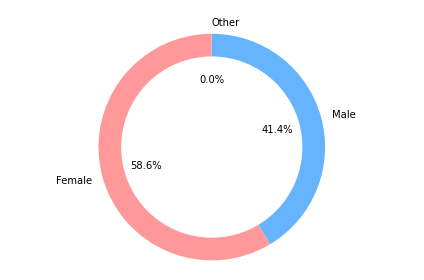

In [29]:
# Quiero ver cómo está distribuido el genero
countplot('gender', 'stroke', brain)
plt.savefig('./img/distribuciongendercountplot.png') 

gender = brain['gender'].value_counts()
pie(gender, ' ')
plt.savefig('./img/distribuciongender.png') 

print(brain.gender.value_counts())  

In [22]:
# Voy a eliminar la fila que contiene el dato erróneo
# Selecciono el dato erróneo en la columna 'gender'
print(display(brain[brain.gender.isin(['Other'])]))

#Compruebo el tamaño antes de eliminarlo
print("Tamaño con el outlier sin eliminar: ", brain.gender.shape)

# # Elimino el outlier
brain = brain.drop(brain.index[brain['gender']=='Other'])

# Compruebo el tamaño con el outlier eliminado
print("Tamaño con el outlier eliminado:", brain.gender.shape)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0,20-30


None
Tamaño con el outlier sin eliminar:  (5106,)
Tamaño con el outlier eliminado: (5105,)


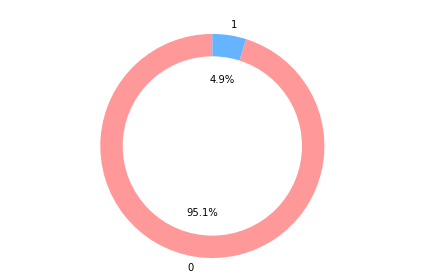

In [35]:
# visualizo el porcentajes de 1
stroke = brain['stroke'].value_counts()
pie(stroke, ' ')
plt.savefig('./img/distribucionstroke.png') 

Yes    3351
No     1754
Name: ever_married, dtype: int64


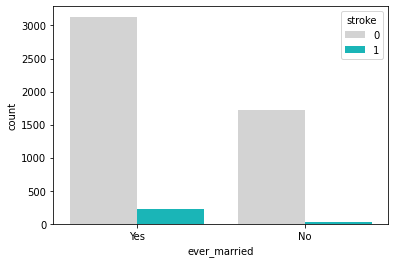

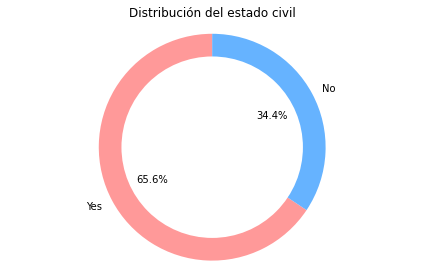

In [38]:
# Quiero ver cómo está distribuido el estado civil
countplot('ever_married', 'stroke', brain)
plt.savefig('./img/distribucionestadocivilcountplot.png') 

married = brain['ever_married'].value_counts()
pie(married, 'Distribución del estado civil')
plt.savefig('./img/distribucionestadocivil.png') 

print(brain.ever_married.value_counts())

0    4829
1     276
Name: heart_disease, dtype: int64


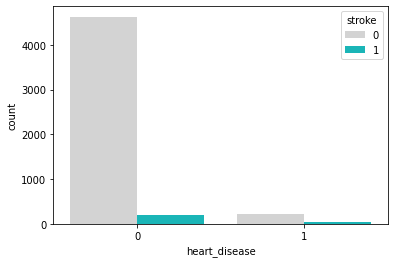

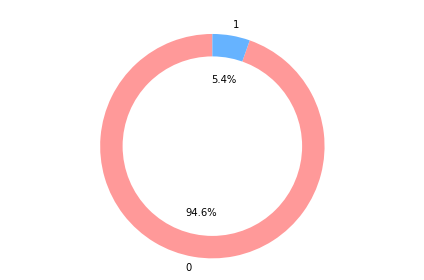

In [23]:
# Quiero ver cómo están distribuidas las enfermedades del corazón
countplot('heart_disease', 'stroke', brain)
plt.savefig('./img/cardiacocountplot.png') 

married = brain['heart_disease'].value_counts()
pie(married, ' ')
plt.savefig('./img/enfermedadcardiaca.png')

print(brain.heart_disease.value_counts())

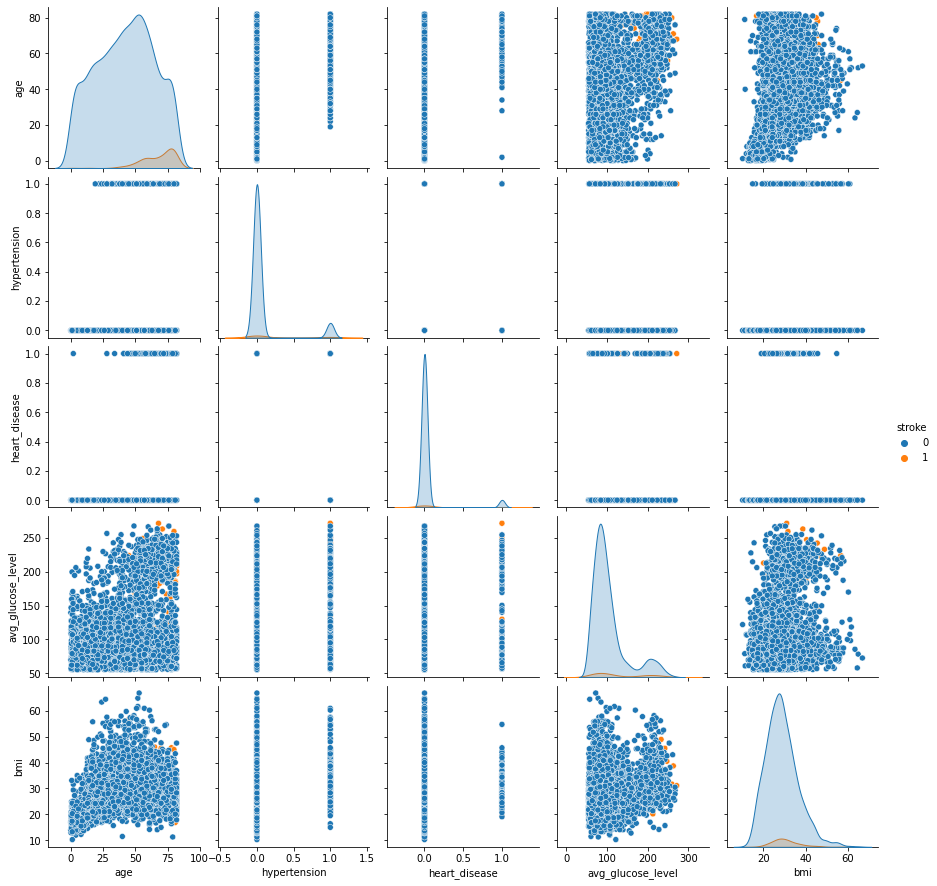

In [41]:
# Hago un pairplot, pero al haber muy poco target, no sé logra apreciar bien, 
# lo probaré cuando lo rellene con los datos sintéticos
sns.pairplot(brain.drop(['id'], axis=1), hue='stroke')
plt.savefig('./img/pairplot.png') 

tamaño x: (9712, 10)
tamaño x: (9712,)
(9712, 12)


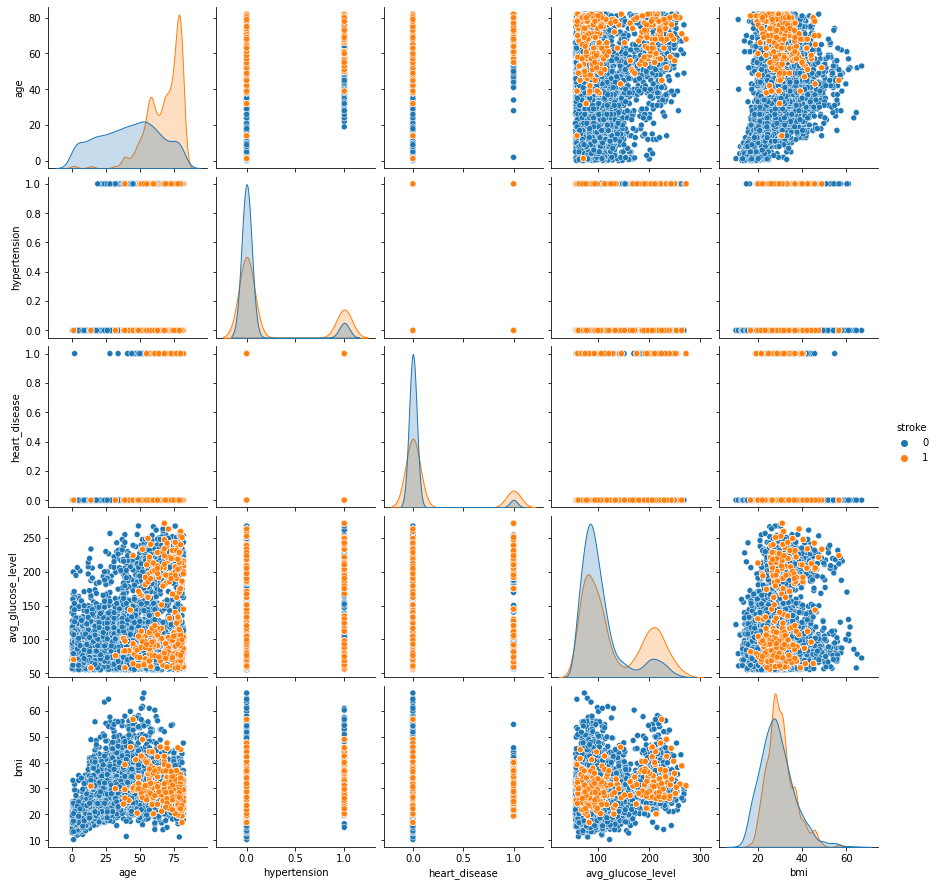

In [83]:
# pairplot con el RandomOverSampler
print("tamaño x:" , X.shape)
print("tamaño x:" , y.shape)

_ = pd.merge(X.reset_index(),y.reset_index())
print(_.shape)

sns.pairplot(_.drop(['index'], axis=1), hue='stroke')
plt.savefig('./img/pairplotoversampler.png') 

stroke               1.000000
age                  0.245193
heart_disease        0.134868
avg_glucose_level    0.132074
hypertension         0.128636
bmi                  0.044533
Name: stroke, dtype: float64


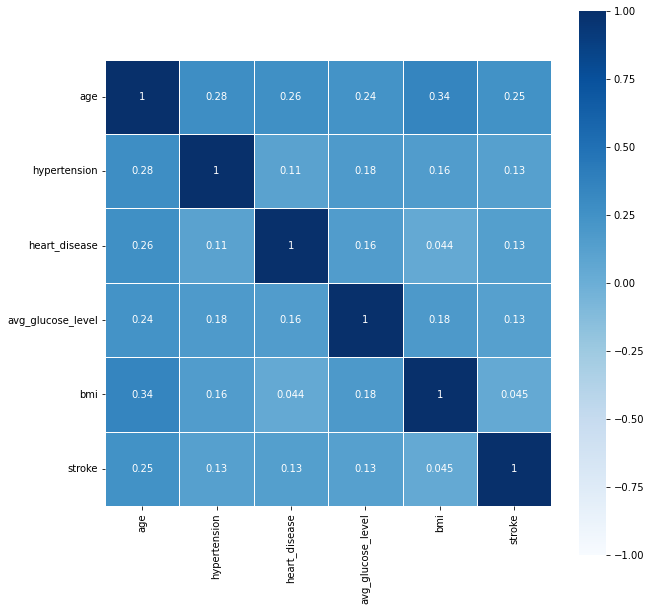

In [42]:
# Quiero ver la correlación de las variables con el target, no veo correlación lineal
corr = np.abs(brain.drop(['id'], axis=1).corr()['stroke']).sort_values(ascending=False)
print(corr)
plt.figure(figsize=(10,10))
sns.heatmap(brain.drop(['id'], axis=1).corr(),
           vmin=-1,
           vmax=1,
           center=0,
           cmap='Blues',
           square=True,
           annot=True,
           linewidths=.5);

interval columns not set, guessing: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']


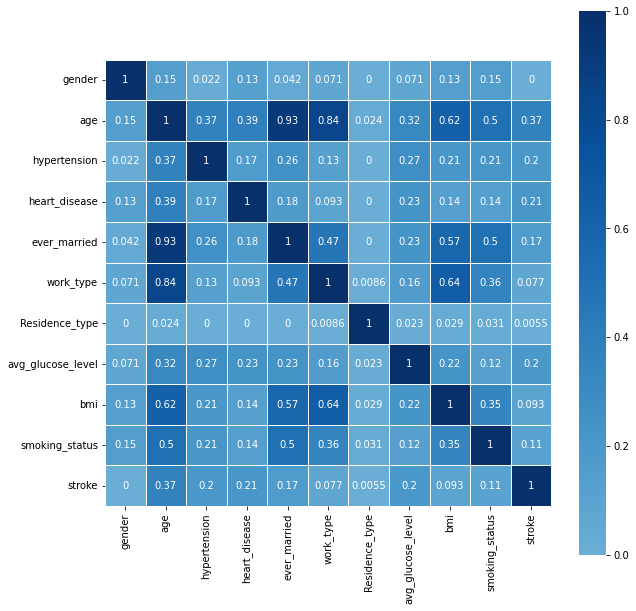

In [44]:
# Quiero ver la correlación de las variables también con las variables categoricas
# No hay correlación lineal, con lo cual la regresión logística no tendrá sentido
import phik
phik_matrix = brain.drop(['id', 'age_group'], axis=1).phik_matrix()
# print(phik_matrix)
plt.figure(figsize=(10,10))
sns.heatmap(phik_matrix,
            vmin=0,
            vmax=1,
            center=0,
            cmap='Blues',
            square=True,
            annot=True,
            linewidths=.5);
plt.savefig('./img/phik.png') 

## Apartado 1: Preparo el dataset para los modelos ML

In [24]:
# Creo datos sintéticos para crear más 1
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

# aprovecho para # eliminar la columna 'id' porque no me aporta información, primero revisaré que no hayan duplicados
print("Tamaño X_train: ", brain.shape)
print("Tamaño único columna id en X_train: ", brain.id.nunique())

# realizo el RandomOverSampler, también elimino la columna 'age_group' que he utilizado para sacar los porcentajes de la edad
# en la columna 'age_group' no miro si hay repetidos, porque es una columna que he creado yo y no me preocupa
X,y = ros.fit_resample(brain.loc[:, "gender":"smoking_status"], brain["stroke"])

Tamaño X_train:  (5105, 13)
Tamaño único columna id en X_train:  5105


In [25]:
# Compruebo los tamaños y el resampling, y veo que ahora ya está el dataset balanceado
print("Tamaño original: ", brain.shape)
print("Tamaño con RandomOverSampler: ", X.shape)
print("\nCantidad de valores del target en el original: \n", brain.stroke.value_counts())
print("\nCantidad de valores del target con el resampling: \n", y.value_counts())

Tamaño original:  (5105, 13)
Tamaño con RandomOverSampler:  (9712, 10)

Cantidad de valores del target en el original: 
 0    4856
1     249
Name: stroke, dtype: int64

Cantidad de valores del target con el resampling: 
 1    4856
0    4856
Name: stroke, dtype: int64


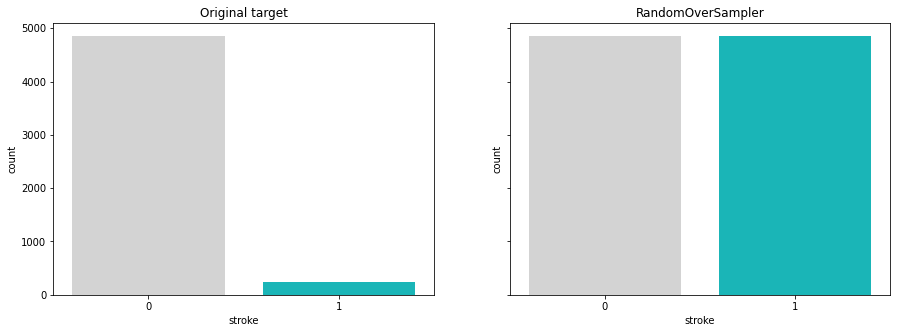

In [26]:
# Gráfica para visualizarlo
fig, axes= plt.subplots(1,2, figsize=(15,5), sharey=True)

# Original target
sns.countplot(x='stroke', data=brain, ax=axes[0], palette=["#D3D3D3",'#00CED1'])
axes[0].set_title("Original target")

# RandomOverSampler
sns.countplot(y,ax=axes[1], palette=["#D3D3D3",'#00CED1'])
axes[1].set_title("RandomOverSampler")
plt.savefig('./img/randomoversampler.png') 

In [48]:
# Hago train y test, para continuar con el análisis y los cambios
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.shape)
print(y.shape)

# Compruebo los tamaños
print("Tamaño del X_train: ", X_train.shape)
print("Tamaño del X_test: ", X_test.shape)
print("Tamaño del y_train: ", y_train.shape)
print("Tamaño del y_test: ", y_test.shape)

(9712, 10)
(9712,)
Tamaño del X_train:  (7769, 10)
Tamaño del X_test:  (1943, 10)
Tamaño del y_train:  (7769,)
Tamaño del y_test:  (1943,)


In [49]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7769 entries, 6889 to 7270
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7769 non-null   object 
 1   age                7769 non-null   float64
 2   hypertension       7769 non-null   int64  
 3   heart_disease      7769 non-null   int64  
 4   ever_married       7769 non-null   object 
 5   work_type          7769 non-null   object 
 6   Residence_type     7769 non-null   object 
 7   avg_glucose_level  7769 non-null   float64
 8   bmi                6983 non-null   float64
 9   smoking_status     7769 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 667.6+ KB


In [50]:
# Quiero ver cuantos nulos hay en la columna 'bmi'.
print(X_train.isnull().sum())

# Quiero ver cuantos missings hay en X_test
print(X_test.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  786
smoking_status         0
dtype: int64
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  174
smoking_status         0
dtype: int64


In [51]:
# quiero ver cual es la mediana de la columna 'bmi'
print(X_train.bmi.median()) # mediana

# relleno los valores faltantes en la columna 'bmi' con la mediana
X_train.bmi.fillna(value=X_train.bmi.median(), inplace=True)

# Relleno los valores faltantes en la columna 'bmi' de X_test con la mediana de X_train
X_test.bmi.fillna(28.6, inplace=True)

28.6


In [52]:
# compruebo el resultado de X_train y X_test con el reemplazo de los datos faltantes, veo que ya no hay missings
print("X_train: \n",X_train.isnull().sum())
print("X_test: \n",X_test.isnull().sum())

X_train: 
 gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64
X_test: 
 gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
dtype: int64


In [53]:
# Aplico un mapeo personalizado para cambiar el contenido de la columna gender y pasarla a binaria
def mapping(x):
    if x == 'Female':
        return 1
    elif x == 'Male':
        return 0
    else:
        return 999

# Lo aplico a X_train
X_train['gender_custom'] = X_train['gender'].apply(mapping)
print(display(X_train.head()))

# Lo aplico a X_test
X_test['gender_custom'] = X_test['gender'].apply(mapping)
print(display(X_test.head()))

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,gender_custom
6889,Female,81.0,0,0,No,Govt_job,Urban,70.30,25.8,smokes,1
3469,Female,34.0,0,0,Yes,Private,Urban,91.02,25.8,never smoked,1
3533,Male,40.0,0,0,No,Govt_job,Urban,197.11,23.9,never smoked,0
5786,Male,66.0,0,0,Yes,Private,Rural,76.46,21.2,formerly smoked,0
7550,Female,70.0,0,1,Yes,Private,Rural,59.35,32.3,formerly smoked,1


None


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,gender_custom
7596,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.6,never smoked,1
4414,Male,66.0,0,0,Yes,Self-employed,Urban,85.82,27.8,never smoked,0
8785,Female,57.0,1,0,Yes,Govt_job,Rural,67.41,32.9,never smoked,1
4681,Female,70.0,0,0,Yes,Self-employed,Rural,96.82,25.0,never smoked,1
2129,Female,71.0,0,1,Yes,Private,Urban,187.88,29.2,formerly smoked,1


None


In [54]:
# Aplico un mapeo personalizado para cambiar el contenido de la columna ever_married y pasarla a binaria
def mapping(x):
    if x == 'Yes':
        return 1
    elif x == 'No':
        return 0
    else:
        return 999

# Lo aplico en X_train
X_train['ever_married_custom'] = X_train['ever_married'].apply(mapping)
print(display(X_train.head()))

# Lo aplico en X_test
X_test['ever_married_custom'] = X_test['ever_married'].apply(mapping)
print(display(X_test.head()))

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,gender_custom,ever_married_custom
6889,Female,81.0,0,0,No,Govt_job,Urban,70.30,25.8,smokes,1,0
3469,Female,34.0,0,0,Yes,Private,Urban,91.02,25.8,never smoked,1,1
3533,Male,40.0,0,0,No,Govt_job,Urban,197.11,23.9,never smoked,0,0
5786,Male,66.0,0,0,Yes,Private,Rural,76.46,21.2,formerly smoked,0,1
7550,Female,70.0,0,1,Yes,Private,Rural,59.35,32.3,formerly smoked,1,1


None


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,gender_custom,ever_married_custom
7596,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.6,never smoked,1,1
4414,Male,66.0,0,0,Yes,Self-employed,Urban,85.82,27.8,never smoked,0,1
8785,Female,57.0,1,0,Yes,Govt_job,Rural,67.41,32.9,never smoked,1,1
4681,Female,70.0,0,0,Yes,Self-employed,Rural,96.82,25.0,never smoked,1,1
2129,Female,71.0,0,1,Yes,Private,Urban,187.88,29.2,formerly smoked,1,1


None


In [55]:
# Aplico un mapeo personalizado para cambiar el contenido de la columna Residence_type y pasarla a binaria
def mapping(x):
    if x == 'Urban':
        return 1
    elif x == 'Rural':
        return 0
    else:
        return 999

# Lo aplico en X_train
X_train['Residence_custom'] = X_train['Residence_type'].apply(mapping)
print(display(X_train.head()))

# Lo aplico en X_test
X_test['Residence_custom'] = X_test['Residence_type'].apply(mapping)
print(display(X_test.head()))

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,gender_custom,ever_married_custom,Residence_custom
6889,Female,81.0,0,0,No,Govt_job,Urban,70.30,25.8,smokes,1,0,1
3469,Female,34.0,0,0,Yes,Private,Urban,91.02,25.8,never smoked,1,1,1
3533,Male,40.0,0,0,No,Govt_job,Urban,197.11,23.9,never smoked,0,0,1
5786,Male,66.0,0,0,Yes,Private,Rural,76.46,21.2,formerly smoked,0,1,0
7550,Female,70.0,0,1,Yes,Private,Rural,59.35,32.3,formerly smoked,1,1,0


None


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,gender_custom,ever_married_custom,Residence_custom
7596,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.6,never smoked,1,1,0
4414,Male,66.0,0,0,Yes,Self-employed,Urban,85.82,27.8,never smoked,0,1,1
8785,Female,57.0,1,0,Yes,Govt_job,Rural,67.41,32.9,never smoked,1,1,0
4681,Female,70.0,0,0,Yes,Self-employed,Rural,96.82,25.0,never smoked,1,1,0
2129,Female,71.0,0,1,Yes,Private,Urban,187.88,29.2,formerly smoked,1,1,1


None


In [56]:
# Hago get_dummies en la columna de tipo de trabajo, lo realizo tanto en X_train como X_test
X_train = pd.get_dummies(X_train, columns=['work_type'], prefix='work', drop_first=True) 
X_test = pd.get_dummies(X_test, columns=['work_type'], prefix='work', drop_first=True)

# Aplico get_dummies también para la columna smoking_status
X_train = pd.get_dummies(X_train, columns=['smoking_status'], prefix='smoking', drop_first=True)
X_test = pd.get_dummies(X_test, columns=['smoking_status'], prefix='smoking', drop_first=True)

In [57]:
# Compuebo los cambios como han quedado
print(display(X_train.head()))
print(display(X_test.head()))

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_custom,ever_married_custom,Residence_custom,work_Never_worked,work_Private,work_Self-employed,work_children,smoking_formerly smoked,smoking_never smoked,smoking_smokes
6889,Female,81.0,0,0,No,Urban,70.30,25.8,1,0,1,0,0,0,0,0,0,1
3469,Female,34.0,0,0,Yes,Urban,91.02,25.8,1,1,1,0,1,0,0,0,1,0
3533,Male,40.0,0,0,No,Urban,197.11,23.9,0,0,1,0,0,0,0,0,1,0
5786,Male,66.0,0,0,Yes,Rural,76.46,21.2,0,1,0,0,1,0,0,1,0,0
7550,Female,70.0,0,1,Yes,Rural,59.35,32.3,1,1,0,0,1,0,0,1,0,0


None


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_custom,ever_married_custom,Residence_custom,work_Never_worked,work_Private,work_Self-employed,work_children,smoking_formerly smoked,smoking_never smoked,smoking_smokes
7596,Female,61.0,0,0,Yes,Rural,202.21,28.6,1,1,0,0,0,1,0,0,1,0
4414,Male,66.0,0,0,Yes,Urban,85.82,27.8,0,1,1,0,0,1,0,0,1,0
8785,Female,57.0,1,0,Yes,Rural,67.41,32.9,1,1,0,0,0,0,0,0,1,0
4681,Female,70.0,0,0,Yes,Rural,96.82,25.0,1,1,0,0,0,1,0,0,1,0
2129,Female,71.0,0,1,Yes,Urban,187.88,29.2,1,1,1,0,1,0,0,1,0,0


None


In [58]:
# Elimino las columnas que les he realizado los encodings
X_train.drop(columns=['gender', 'Residence_type', 'ever_married'], inplace=True) # ha borrado sola la columna de residence type, no me sale ya
print(display(X_train.head()))

# Elimino las mismas columnas en X_test
X_test.drop(columns=['gender', 'Residence_type', 'ever_married'], inplace=True)
print(display(X_test.head()))


,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_custom,ever_married_custom,Residence_custom,work_Never_worked,work_Private,work_Self-employed,work_children,smoking_formerly smoked,smoking_never smoked,smoking_smokes
6889,81.0,0,0,70.30,25.8,1,0,1,0,0,0,0,0,0,1
3469,34.0,0,0,91.02,25.8,1,1,1,0,1,0,0,0,1,0
3533,40.0,0,0,197.11,23.9,0,0,1,0,0,0,0,0,1,0
5786,66.0,0,0,76.46,21.2,0,1,0,0,1,0,0,1,0,0
7550,70.0,0,1,59.35,32.3,1,1,0,0,1,0,0,1,0,0


None


,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_custom,ever_married_custom,Residence_custom,work_Never_worked,work_Private,work_Self-employed,work_children,smoking_formerly smoked,smoking_never smoked,smoking_smokes
7596,61.0,0,0,202.21,28.6,1,1,0,0,0,1,0,0,1,0
4414,66.0,0,0,85.82,27.8,0,1,1,0,0,1,0,0,1,0
8785,57.0,1,0,67.41,32.9,1,1,0,0,0,0,0,0,1,0
4681,70.0,0,0,96.82,25.0,1,1,0,0,0,1,0,0,1,0
2129,71.0,0,1,187.88,29.2,1,1,1,0,1,0,0,1,0,0


None


## Apartado 2: Implementación de los modelos ML
La métrica que más me interesa en este caso es Recall, porque quiero reducir los falsos negativos y son los que más nos perjudican en este caso en concreto.

### Árbol de decisión

In [64]:
# creo el modelo
tree_clf = DecisionTreeClassifier(max_depth = 10,random_state=42, max_features=4)

# entreno el modelo
tree_clf.fit(X_train,y_train) 
predictions = tree_clf.predict(X_train)

# miro el score en X_train
print("Accuracy en train: ", accuracy_score(y_train,predictions))
print("Recall en train:   ", recall_score(y_train, predictions)) 
print("F1 en train:       ", f1_score(y_train, predictions))
print("AUC en train:      ", roc_auc_score(y_train, predictions))

# miro el score en X_test
predictions = tree_clf.predict(X_test)
print("\nAccuracy en test: ", accuracy_score(y_test, predictions))
print("Recall en test:     ", recall_score(y_test, predictions))
print("F1 en test:         ", f1_score(y_test, predictions))
print("AUC en test:        ", roc_auc_score(y_test, predictions))

# veo las feature importances del árbol de decisión
forest_importances = pd.Series(tree_clf.feature_importances_, index=X_train.columns, name='Feature importances Árbol de decisión')
pd.DataFrame(forest_importances.sort_values(ascending=False))


Accuracy en train:  0.9119577809241859
Recall en train:    0.961449498843485
F1 en train:        0.9162380602498164
AUC en train:       0.9118748267812061

Accuracy en test:  0.903242408646423
Recall en test:      0.9585492227979274
F1 en test:          0.9077526987242394
AUC en test:         0.9036099897220721


,Feature importances Árbol de decisión
age,0.573829
avg_glucose_level,0.167986
bmi,0.102052
smoking_never smoked,0.031029
ever_married_custom,0.025733
work_Private,0.023073
smoking_smokes,0.014385
work_Self-employed,0.013138
smoking_formerly smoked,0.012153
hypertension,0.011971


## SVM

In [79]:
# Preparo el modelo de Support Vector Machine

# con sigmoid
svm_clf = svm.SVC(kernel='sigmoid', C= 10, gamma='scale', probability=True, degree=5, random_state=42)

# entreno el modelo
svm_clf.fit(X_train, y_train)  

# predicciones en X_train
print('\nSVM Kernel Sigmoid Accuracy en train: ',accuracy_score(y_train,svm_clf.predict(X_train)))
print('SVM Kernel Sigmoid Recall en train: ',recall_score(y_train,svm_clf.predict(X_train)))
print('SVM Kernel Sigmoid F1 en train: ',f1_score(y_train,svm_clf.predict(X_train)))
print('SVM Kernel Sigmoid Roc AUC en train: ',roc_auc_score(y_train,svm_clf.predict(X_train)))

pred = svm_clf.predict(X_test)
print('\nSVM Kernel Sigmoid Accuracy en test:', accuracy_score(y_test,pred))
print('SVM Kernel Sigmoid Recall en test:', recall_score(y_test,pred))
print('SVM Kernel Sigmoid F1 en test:', f1_score(y_test,pred))
print('SVM Kernel Sigmoid Roc AUC Accuracy en test:', roc_auc_score(y_test,pred))


# Con kernel 'poly'
svm_clf2 = svm.SVC(kernel='poly', C= 100, random_state=42) 
svm_clf2.fit(X_train, y_train)  

# predicciones en X_train
print('\nSVM Kernel Poly Accuracy en train: ',accuracy_score(y_train,svm_clf2.predict(X_train)))
print('SVM Kernel Poly Recall en train: ',recall_score(y_train,svm_clf2.predict(X_train)))
print('SVM Kernel Poly F1 en train: ',f1_score(y_train,svm_clf2.predict(X_train)))
print('SVM Kernel Poly Roc AUC en train: ',roc_auc_score(y_train,svm_clf2.predict(X_train)))

pred = svm_clf2.predict(X_test)
print('\nSVM Kernel Poly Accuracy en test:', accuracy_score(y_test,pred))
print('SVM Kernel Poly Recall en test:', recall_score(y_test,pred))
print('SVM Kernel Poly F1 en test:', f1_score(y_test,pred))
print('SVM Kernel Poly Roc AUC Accuracy en test:', roc_auc_score(y_test,pred))


# con LinearSVC
svc = svm.LinearSVC(C=1, loss="hinge", random_state=42)
svc.fit(X_train, y_train)  

# predicciones en X_train
print('\nLinear SVM  Accuracy en train: ',accuracy_score(y_train,svc.predict(X_train)))
print('Linear SVM Recall en train: ',recall_score(y_train,svc.predict(X_train)))
print('Linear SVM F1 en train: ',f1_score(y_train,svc.predict(X_train)))
print('Linear SVM Roc AUC en train: ',roc_auc_score(y_train,svc.predict(X_train)))

pred = svm_clf2.predict(X_test)
print('\nLinear SVM Accuracy en test:', accuracy_score(y_test,pred))
print('Linear SVM Recall en test:', recall_score(y_test,pred))
print('Linear SVM F1 en test:', f1_score(y_test,pred))
print('Linear SVM Roc AUC Accuracy en test:', roc_auc_score(y_test,pred))


SVM Kernel Sigmoid Accuracy en train:  0.4306860599819797
SVM Kernel Sigmoid Recall en train:  0.43279362631714213
SVM Kernel Sigmoid F1 en train:  0.4322936721858554
SVM Kernel Sigmoid Roc AUC en train:  0.43068252744428537

SVM Kernel Sigmoid Accuracy en test: 0.4395265054040144
SVM Kernel Sigmoid Recall en test: 0.43523316062176165
SVM Kernel Sigmoid F1 en test: 0.4354587869362364
SVM Kernel Sigmoid Roc AUC Accuracy en test: 0.43949797090392784

SVM Kernel Poly Accuracy en train:  0.7811816192560175
SVM Kernel Poly Recall en train:  0.7910562837316885
SVM Kernel Poly F1 en train:  0.7836048879837068
SVM Kernel Poly Roc AUC en train:  0.7811650681164889

SVM Kernel Poly Accuracy en test: 0.7910447761194029
SVM Kernel Poly Recall en test: 0.7958549222797927
SVM Kernel Poly F1 en test: 0.7909371781668382
SVM Kernel Poly Roc AUC Accuracy en test: 0.7910767453934752

Linear SVM  Accuracy en train:  0.508430943493371
Linear SVM Recall en train:  0.020560267283474685
Linear SVM F1 en trai

## Ensemble


In [70]:
# Bagging
kfold = model_selection.KFold(n_splits=10) # 10 muestras
dtc = DecisionTreeClassifier()
bagging = BaggingClassifier(base_estimator=dtc, n_estimators=1, random_state=42, max_samples=80, max_features=10)
results_bagg = model_selection.cross_val_score(bagging, X_train, y_train, cv=kfold).mean()
print(results_bagg)

bagging.fit(X_train, y_train)

# predicciones de Bagging
print("Accuracy en train: ",accuracy_score(y_train,bagging.predict(X_train)))
print('\nBagging Accuracy en train: ',accuracy_score(y_train,bagging.predict(X_train)))
print('Bagging Recall en train: ',recall_score(y_train,bagging.predict(X_train)))
print('Bagging F1 en train: ',f1_score(y_train,bagging.predict(X_train)))
print('Bagging Roc AUC en train: ',roc_auc_score(y_train,bagging.predict(X_train)))

y_test_pred = bagging.predict(X_test)
print("Accuracy en test: ", accuracy_score(y_test, y_test_pred))
print('\nBagging Accuracy en test:', accuracy_score(y_test,y_test_pred))
print('Bagging Recall en test:', recall_score(y_test,y_test_pred))
print('Bagging F1 en test:', f1_score(y_test,y_test_pred))
print('Bagging Roc AUC Accuracy en test:', roc_auc_score(y_test,y_test_pred))


# Random forest
randomforest = RandomForestClassifier(n_estimators=100, max_features = 3, random_state = 42)
results_rf = model_selection.cross_val_score(randomforest, X_train, y_train, cv=10).mean()
print("Random Forest en train: ",results_rf)

RandomForest = RandomForestClassifier(n_estimators=100, max_features = 6, random_state = 42, max_depth=6) # lo pondre en 6 o 6
RandomForest.fit(X_train, y_train)


print('\nRandomForest Accuracy en train: ',accuracy_score(y_train,RandomForest.predict(X_train)))
print('RandomForest Recall en train: ',recall_score(y_train,RandomForest.predict(X_train)))
print('RandomForest F1 en train: ',f1_score(y_train,RandomForest.predict(X_train)))
print('RandomForest Roc AUC en train: ',roc_auc_score(y_train,RandomForest.predict(X_train)))

y_pred = RandomForest.predict(X_test)
print('\nRandomForest Accuracy en test:', accuracy_score(y_test,y_pred))
print('RandomForest Recall en test:', recall_score(y_test,y_pred))
print('RandomForest F1 en test:', f1_score(y_test,y_pred))
print('RandomForest Roc AUC Accuracy en test:', roc_auc_score(y_test,y_pred))



0.6942957316668658
Accuracy en train:  0.6851589651177757

Bagging Accuracy en train:  0.6851589651177757
Bagging Recall en train:  0.77769210999743
Bagging F1 en train:  0.7121675688397271
Bagging Roc AUC en train:  0.6850038683045427
Accuracy en test:  0.6716417910447762

Bagging Accuracy en test: 0.6716417910447762
Bagging Recall en test: 0.7751295336787565
Bagging F1 en test: 0.7010309278350515
Bagging Roc AUC Accuracy en test: 0.6723295930152473
Random Forest en train:  0.9882864639307938

RandomForest Accuracy en train:  0.8495301840648732
RandomForest Recall en train:  0.930609097918273
RandomForest F1 en train:  0.8610153370586137
RandomForest Roc AUC en train:  0.8493942859369601

RandomForest Accuracy en test: 0.8440555841482243
RandomForest Recall en test: 0.927461139896373
RandomForest F1 en test: 0.8552317247969422
RandomForest Roc AUC Accuracy en test: 0.8446099155514585


In [71]:
# Adaboost
adaboost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=2), n_estimators= 30, random_state=42)
results_ada = model_selection.cross_val_score(adaboost, X_train, y_train, cv=10).mean()
print("\nAdaBoost en train con validación cruzada: ",results_ada)

AdaBoost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=2), n_estimators= 30, random_state=42)
AdaBoost.fit(X_train, y_train)


print('\nAdaboost Accuracy en train: ',accuracy_score(y_train,AdaBoost.predict(X_train)))
print('Adaboost Recall en train: ',recall_score(y_train,AdaBoost.predict(X_train)))
print('Adaboost F1 en train: ',f1_score(y_train,AdaBoost.predict(X_train)))
print('Adaboost Roc AUC en train: ',roc_auc_score(y_train,AdaBoost.predict(X_train)))

y_pred = AdaBoost.predict(X_test)
print('\nAbaBoost Accuracy en test:', accuracy_score(y_test,y_pred))
print('AbaBoost Recall en test:', recall_score(y_test,y_pred))
print('AdaBoost F1 en test:', f1_score(y_test,y_pred))
print('AdaBoost Roc AUC Accuracy en test:', roc_auc_score(y_test,y_pred))



AdaBoost en train con validación cruzada:  0.847857540898778

Adaboost Accuracy en train:  0.8594413695456301
Adaboost Recall en train:  0.921099974299666
Adaboost F1 en train:  0.8677966101694915
Adaboost Roc AUC en train:  0.8593380222194564

AbaBoost Accuracy en test: 0.8558929490478642
AbaBoost Recall en test: 0.9202072538860103
AdaBoost F1 en test: 0.8638132295719845
AdaBoost Roc AUC Accuracy en test: 0.8563203958591606


In [72]:
# GradientBoosting
gradientboosting = GradientBoostingClassifier(n_estimators = 100, random_state= 42)
results_gb = model_selection.cross_val_score(gradientboosting, X_train, y_train, cv=10).mean()   
print("\nGradientBoosting en train con validación cruzada: ",results_gb)

GradientBoosting = GradientBoostingClassifier(n_estimators = 100, random_state= 42)
GradientBoosting.fit(X_train, y_train)


# saco las métricas de GradientBoosting
print('\nGradientBoosting Accuracy en train: ',accuracy_score(y_train,GradientBoosting.predict(X_train)))
print('GradientBoosting Recall en train: ',recall_score(y_train,GradientBoosting.predict(X_train)))
print('GradientBoosting F1 en train: ',f1_score(y_train,GradientBoosting.predict(X_train)))
print('GradientBoosting Roc AUC en train: ',roc_auc_score(y_train,GradientBoosting.predict(X_train)))

y_pred = GradientBoosting.predict(X_test)
print('\nGradientBoosting Accuracy en test:', accuracy_score(y_test,y_pred))
print('GradientBoosting Recall en test:', recall_score(y_test,y_pred))
print('GradientBoosting F1 en test:', f1_score(y_test,y_pred))
print('GradientBoosting Roc AUC Accuracy en test:', roc_auc_score(y_test,y_pred))



# XGBoost, le pongo más parametros porque me estaba dando muy alto
xgboost = XGBClassifier(n_estimators=100, use_label_encoder= False, eval_metric= 'logloss')
results_xgb = model_selection.cross_val_score(xgboost, X_train,y_train, cv=10).mean()
print("\nXGBoost en train: ",results_xgb)

XGBoost = XGBClassifier(n_estimators=11, use_label_encoder= False, eval_metric= 'logloss', 
                subsample=1.0, eta=0.1)
XGBoost.fit(X_train, y_train)


# saco las métricas de XGBoost, le pongo más parametros porque me estaba dando muy alto
print('\nXGBoost Accuracy en train: ',accuracy_score(y_train,XGBoost.predict(X_train)))
print('XGBoost Recall en train: ',recall_score(y_train,XGBoost.predict(X_train)))
print('XGBoost F1 en train: ',f1_score(y_train,XGBoost.predict(X_train)))
print('XGBoostRoc AUC en train: ',roc_auc_score(y_train,XGBoost.predict(X_train)))

y_pred = XGBoost.predict(X_test)
print('\nXGBoost Accuracy en test:', accuracy_score(y_test,y_pred))
print('XGBoost Recall en test:', recall_score(y_test,y_pred))
print('XGBoost F1 en test:', f1_score(y_test,y_pred))
print('XGBoost Roc AUC Accuracy en test:', roc_auc_score(y_test,y_pred))


GradientBoosting en train con validación cruzada:  0.8527484774907454

GradientBoosting Accuracy en train:  0.8582829192946325
GradientBoosting Recall en train:  0.9221279876638396
GradientBoosting F1 en train:  0.8669807901413555
GradientBoosting Roc AUC en train:  0.8581759071893206

GradientBoosting Accuracy en test: 0.845084920226454
GradientBoosting Recall en test: 0.9139896373056995
GradientBoosting F1 en test: 0.8542372881355932
GradientBoosting Roc AUC Accuracy en test: 0.8455428759125635

XGBoost en train:  0.9732267245153843

XGBoost Accuracy en train:  0.8965117775775518
XGBoost Recall en train:  0.9704446157800052
XGBoost F1 en train:  0.9037817137386309
XGBoostRoc AUC en train:  0.8963878571421945

XGBoost Accuracy en test: 0.8769943386515697
XGBoost Recall en test: 0.9616580310880829
XGBoost F1 en test: 0.8859188544152744
XGBoost Roc AUC Accuracy en test: 0.8775570319039596


In [76]:
# Creo el facture importances de cada variables de arriba y veo las variables más importantes
forest_importances_XGBoost = pd.Series(XGBoost.feature_importances_, index=X_train.columns, name='Feature importances XGBoost')
XGBoost_importances = pd.DataFrame(forest_importances_XGBoost.sort_values(ascending=False))

forest_importances_GradientBoosting = pd.Series(GradientBoosting.feature_importances_, index=X_train.columns, name='Feature importances GradientBoosting')
GradientBoosting_importances = pd.DataFrame(forest_importances_GradientBoosting.sort_values(ascending=False))

forest_importances_AdaBoost = pd.Series(AdaBoost.feature_importances_, index=X_train.columns, name='Feature importances AdaBoost')
AdaBoost_importances = pd.DataFrame(forest_importances_AdaBoost.sort_values(ascending=False))

forest_importances_RandomForest = pd.Series(RandomForest.feature_importances_, index=X_train.columns, name='Feature importances RandomForest')
RandomFostest_importances = pd.DataFrame(forest_importances_RandomForest.sort_values(ascending=False))
RandomFostest_importances

,Feature importances RandomForest
age,0.620893
avg_glucose_level,0.114612
bmi,0.082920
ever_married_custom,0.047126
work_children,0.028874
hypertension,0.027541
heart_disease,0.027431
smoking_never smoked,0.014333
work_Self-employed,0.009185
gender_custom,0.006391


In [74]:
print(AdaBoost_importances)
print(GradientBoosting_importances)

                         Feature importances AdaBoost
avg_glucose_level                            0.342317
bmi                                          0.319239
age                                          0.231116
smoking_formerly smoked                      0.023955
heart_disease                                0.023335
work_Self-employed                           0.014722
work_children                                0.013691
hypertension                                 0.009876
work_Private                                 0.008448
ever_married_custom                          0.008128
smoking_smokes                               0.005172
gender_custom                                0.000000
Residence_custom                             0.000000
work_Never_worked                            0.000000
smoking_never smoked                         0.000000
                         Feature importances GradientBoosting
age                                                  0.701266
avg_glucose_

In [75]:
print(XGBoost_importances)

                         Feature importances XGBoost
age                                         0.336090
smoking_never smoked                        0.091821
heart_disease                               0.082239
ever_married_custom                         0.057349
avg_glucose_level                           0.057011
hypertension                                0.055266
bmi                                         0.051633
work_children                               0.050272
work_Private                                0.047906
gender_custom                               0.041157
smoking_smokes                              0.038677
work_Self-employed                          0.038159
Residence_custom                            0.029873
smoking_formerly smoked                     0.022549
work_Never_worked                           0.000000


## Redes Neuronales

In [82]:
# Probaré dos redes Neurolanes
sc = StandardScaler()
sc.fit(X_train)
X_train_s = sc.transform(X_train)
X_test_s = sc.transform(X_test)

per_clf = Perceptron(tol=1e-5, random_state=42, max_iter=100,alpha=0.0001, n_jobs=5 ) #
per_clf.fit(X_train_s, y_train)

print('\nEstandarizado Perceptron Accuracy en train: ',accuracy_score(y_train,per_clf.predict(X_train_s)))
print('Estandarizado Perceptron Recall en train:     ',recall_score(y_train,per_clf.predict(X_train_s)))
print('Estandarizado Perceptron F1 en train:         ',f1_score(y_train,per_clf.predict(X_train_s)))
print('Estandarizado Perceptron Roc AUC en train:    ',roc_auc_score(y_train,per_clf.predict(X_train_s)))

y_pred = per_clf.predict(X_test_s)
print('\nEstandarizado Perceptron Accuracy en test:      ', accuracy_score(y_test,y_pred))
print('Estandarizado Perceptron Recall en test:          ', recall_score(y_test,y_pred))
print('Estandarizado Perceptron F1 en test:              ', f1_score(y_test,y_pred))
print('Estandarizado Perceptron Roc AUC en test:         ', roc_auc_score(y_test,y_pred))


# Multi-Layer Perceptron Classifier Estandarizado, veo que este modelo es el que mejor resultado me da de todos
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scal = scaler.transform(X_train)
X_test_scal = scaler.transform(X_test)

mlp = MLPClassifier(max_iter=500, random_state=42, activation='logistic')
mlp.fit(X_train_scal, y_train) 
print(mlp.score(X_train_scal, y_train))
print(mlp.score(X_test_scal, y_test))
print('\nMulti-Layer Perceptron estandarizado Accuracy en train: ',accuracy_score(y_train,mlp.predict(X_train_scal)))
print('Multi-Layer Perceptron estandarizado Recall en train:     ',recall_score(y_train,mlp.predict(X_train_scal)))
print('Multi-Layer Perceptron estandarizado F1 en train:         ',f1_score(y_train,mlp.predict(X_train_scal)))
print('Multi-Layer Perceptron estandarizado Roc AUC en train:    ',roc_auc_score(y_train,mlp.predict(X_train_scal)))

y_pred = mlp.predict(X_test_scal)
print('\nMulti-Layer Perceptron estandarizado Accuracy en test:      ', accuracy_score(y_test,y_pred))
print('Multi-Layer Perceptron estandarizado Recall en test:          ', recall_score(y_test,y_pred))
print('Multi-Layer Perceptron estandarizado F1 en test:              ', f1_score(y_test,y_pred))
print('Multi-Layer Perceptron estandarizado Roc AUC en test:         ', roc_auc_score(y_test,y_pred))


Estandarizado Perceptron Accuracy en train:  0.7127043377526066
Estandarizado Perceptron Recall en train:      0.8021074273965562
Estandarizado Perceptron F1 en train:          0.7366060892140665
Estandarizado Perceptron Roc AUC en train:     0.7125544872929145

Estandarizado Perceptron Accuracy en test:       0.7231085949562532
Estandarizado Perceptron Recall en test:           0.8093264248704664
Estandarizado Perceptron F1 en test:               0.7438095238095238
Estandarizado Perceptron Roc AUC en test:          0.7236816173432087
0.9307504183292573
0.9114770972722593

Multi-Layer Perceptron estandarizado Accuracy en train:  0.9307504183292573
Multi-Layer Perceptron estandarizado Recall en train:      0.9725006425083527
Multi-Layer Perceptron estandarizado F1 en train:          0.9336294103133482
Multi-Layer Perceptron estandarizado Roc AUC en train:     0.9306804398720206

Multi-Layer Perceptron estandarizado Accuracy en test:       0.9114770972722593
Multi-Layer Perceptron estan

## Conclusión:
**El mejor modelo considerando la métrica Recall, es el XGBoost con un 96% de score, y las redes neuronales Multi-Layer Perceptron con un 97%.
Considero que elegir el model XGBoost sería la mejor opción, aunque se reduce un 1% el resultado, pero sabemos en qué se ha basado el modelo (feature importances), y opino que es importante para la predicción que queremos hacer.**
